# t-Tests, Student's t-Distribution

## Single Sample t-Test

## Recalling the formula for calculating a *z*-score: 
$$ z = \frac{x_i-\mu}{\sigma} $$

The **single-sample *t*-test** is a related concept and is defined by
$$ t = \frac{\bar{x} - \mu_0}{s_{\bar{x}}} $$
where
* $\bar{x}$ is the sample mean
* $\mu_0$ is a reference mean, e.g., known population mean or "null hypothesis" mean
* $s_{\bar{x}}$ is the sample standard error

Based on the formula above, the t-value can be calculated as

In [6]:
import numpy as np
import scipy.stats as st

# Define our sample of 4 measurements
x = [48, 50, 54, 60]

# Use a reference mean of 50
mu_0 = 50

# Calculate the t-statistic
t = (np.mean(x)-mu_0)/st.sem(x)

t

1.1338934190276817

## Conversion to p-values from t-values

The [Student's t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) plays a critical role in converting from t-values to p-values, and can be implemented as in the following cell.

In [11]:
def p_from_t(t: float, sample_size: int) -> np.ndarray:
	# As is common in hypothesis tests, there are $n-1$ degrees of freedom
  return 2 * st.t.cdf(-abs(t), sample_size-1)

The p-value may then be evaluated by calling this function.

In [12]:
p_from_t(t, len(x))

0.3392540508564543

Interpetation: There is a 33.9% chance that we would get a mean of $\bar{x}$ by chance alone. Thus this does not pass the statistical significance threshold of 5%.

This process is implemented for us by `scipy.stats`'s 1-sample t-test method:

In [13]:
st.ttest_1samp(x, mu_0)

TtestResult(statistic=1.1338934190276817, pvalue=0.3392540508564543, df=3)

## Welch's Independent *t*-test

The single sample t-test is helpful in situations where we have a reference mean. However in practice this is uncommon. A more realistic scenario is having 2 (or more) samples whose means we would like to compare with eachother. This is the setting in which an independent t-test is appropriate.

The Welch t-test, first formualted by statistician Bernard Lewis Welch is given by
$$ t = \frac{\bar{x} - \bar{y}}{\sqrt{\frac{s^2_x}{n_x} + \frac{s^2_y}{n_y}}} $$
where,
* $\bar{x}$ and $\bar{y}$ are the sample means
* $s^2_x$ and $s^2_y$ are the sample variances
* $n_x$ and $n_y$ are the sample sizes

Let us use the Welch t-test on a dataset of Penguin information to determine if it is statistically significant that the male Adelie penguins in the dataset are heavier than the female Adelie penguins.

In [16]:
import seaborn as sns
penguins = sns.load_dataset('penguins').dropna()  # some rows are missing data

penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


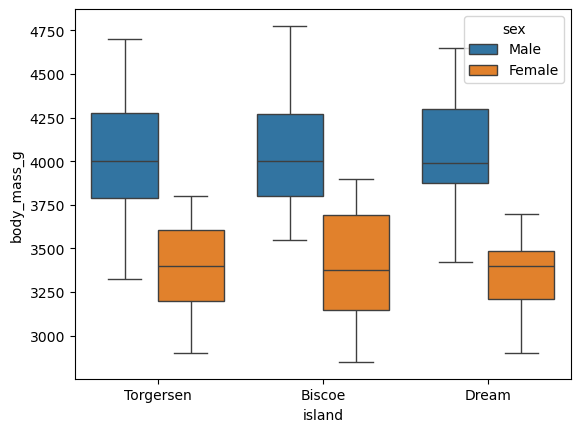

In [18]:
adelie = penguins[penguins.species == 'Adelie']
_ = sns.boxplot(x='island', y='body_mass_g', hue='sex', data=adelie)

In [21]:
female_weights = adelie[adelie.sex == 'Female']['body_mass_g'].to_numpy()/1000
male_weights = adelie[adelie.sex == 'Male']['body_mass_g'].to_numpy()/1000

t = (female_weights.mean()-male_weights.mean()) \
	/ np.sqrt(female_weights.var(ddof=1)/female_weights.size + male_weights.var(ddof=1)/male_weights.size)
t

-13.126285923485879

To calculate the p-value associated with this t-statistic, we need to know the degrees of freedom. These are estimated by the Welch-Satterthwaite equation, which is defined as

In [22]:
def ws_eqn(sx, sy, nx, ny):
	return (sx / nx + sy / ny)**2 / (sx**2 / (nx**2 * (nx - 1)) + sy**2 / (ny**2 * (ny - 1)))

In [24]:
degrees_of_freedom = ws_eqn(female_weights.var(ddof=1), male_weights.var(ddof=1), female_weights.size, male_weights.size)
degrees_of_freedom

135.69357893530386

Now we may calculate the p-value using the function we defined previously

In [26]:
p_from_t(t, degrees_of_freedom+1)

6.402319748031518e-26

Interpretation: This is an extremely low p-value given a significance threshold of 0.05. This means that the weights of female and male penguins are different with high statistical significance.

Again, `scipy.stats` has a built in method to perform this analysis, `ttest_ind`.

In [27]:
st.ttest_ind(female_weights, male_weights, equal_var=False)

TtestResult(statistic=-13.126285923485879, pvalue=6.402319748031518e-26, df=135.69357893530386)

## Paired t-Test